## Introduction

In this test task you will have an opportunity to demonstrate your skills of a Data Scientist from various angles - processing data, analyzing and vizalizing it, finding insights, applying predictive techniques and explaining your reasoning about it.

The task is based around a bike sharing dataset openly available at UCI Machine Learning Repository [1].

Please go through the steps below, build up the necessary code and comment on your choices.

## Part 1 - Data Loading and Environment Preparation

**Tasks:**
1. Prepare a Python 3 virtual environment (with virtualenv command). requirements.txt output of pip freeze command should be included as part of your submission.
2. Load the data from UCI Repository and put it into the same folder with the notebook. The link to it is https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset . Here is an available mirror in case the above website is down: https://data.world/uci/bike-sharing-dataset
3. Load the data into Python runtime as Pandas dataframe.
4. Split the data into two parts. One dataset containing the last 30 days and one dataset with the rest. You will need the dataset with the last 30 days in part 5  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from pylab import rcParams
from prettytable import PrettyTable

import warnings
warnings.filterwarnings('ignore')

In [2]:
day_df = pd.read_csv("day.csv")

In [3]:
day_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


**Answers / comments / reasoning:**

-

In [4]:
# Renaming columns names to more readable names
day_df.rename(columns={'instant':'rec_id',
                        'dteday':'datetime',
                        'holiday':'is_holiday',
                        'workingday':'is_workingday',
                        'weathersit':'weather_situation',
                        'temp': 'temperature',
                        'atemp': 'feeling_temperature',
                        'hum':'humidity',
                        'mnth':'month',
                        'cnt':'total_count',
                        'hr':'hour',
                        'yr':'year'},inplace=True)

# date time conversion
day_df['datetime'] = pd.to_datetime(day_df.datetime)

#Features and Target
category_features = ['season', 'year', 'month', 'is_holiday', 'weekday', 'is_workingday', 'weather_situation']
number_features = ['count_lag1', 'temperature', 'feeling_temperature', 'humidity', 'windspeed', 'casual', 'registered']

features= category_features + number_features
target = ['total_count']

In [5]:
#Setting proper data types of categorical features
for cat_feat in category_features:
    day_df[cat_feat] = day_df[cat_feat].astype('category')
day_df[category_features].describe()

,season,year,month,is_holiday,weekday,is_workingday,weather_situation
count,731,731,731,731,731,731,731
unique,4,2,12,2,7,2,3
top,3,1,12,0,6,1,1
freq,188,366,62,710,105,500,463


In [6]:
#Creating a feature which is lagged version of total count. ie. feature to know previous day rental count to predict next day count  
day_df['count_lag1'] = day_df['total_count'].shift(1)
day_df = day_df.dropna()
day_df['count_lag1'] = day_df['count_lag1'].astype('int')

***Split the data into two parts. One dataset containing the last 30 days and one dataset with the rest. ***

In [7]:
last30days_df = day_df[day_df['datetime'] >= "2012-12-01"]
day_df = day_df[day_df['datetime'] < "2012-12-01"]

## Part 2 - Data Processing and Analysis

**Tasks:**
1. Perform all needed steps to load and clean the data. Please comment the major steps of your code.
2. Visualise rentals of bikes per day.
3. Assume that each bike has exactly maximum 12 rentals per day.
    * Find the maximum number of bicycles `nmax` that was needed in any one day.
    * Find the 95%-percentile of bicycles `n95` that was needed in any one day.
5. Vizalize the distribution of the covered days depending on the number of available bicycles (e.g. `nmax` bicycles would cover 100% of days, `n95` covers 95%, etc.)


***Visualise rentals of bikes per day***

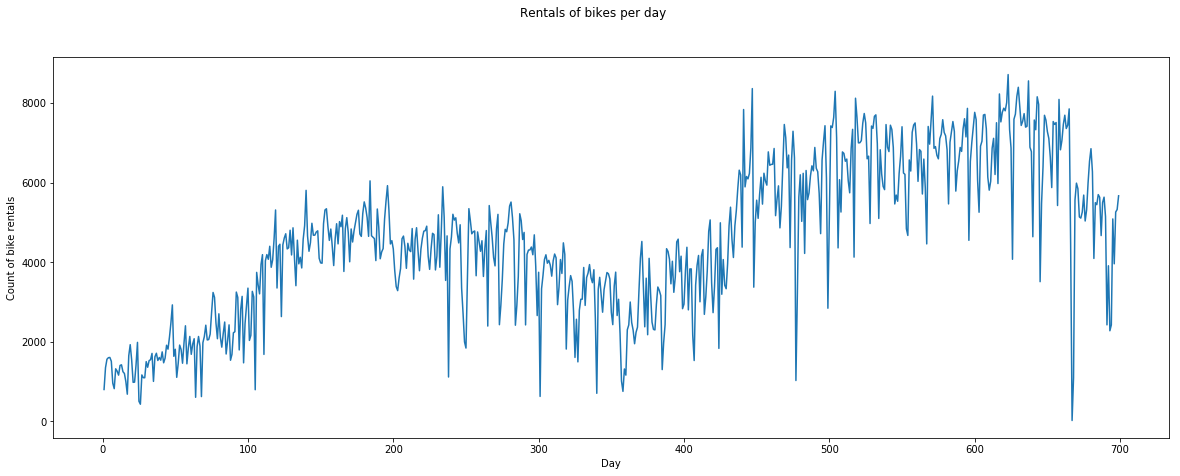

In [8]:
plt.figure(figsize = (20, 7))
plt.plot(day_df['total_count'])
plt.ylabel('Count of bike rentals')
plt.xlabel('Day')
plt.suptitle("Rentals of bikes per day")
plt.show()

**Interpretation:** Bikes are hired more during 2012 in compare to 2011. 

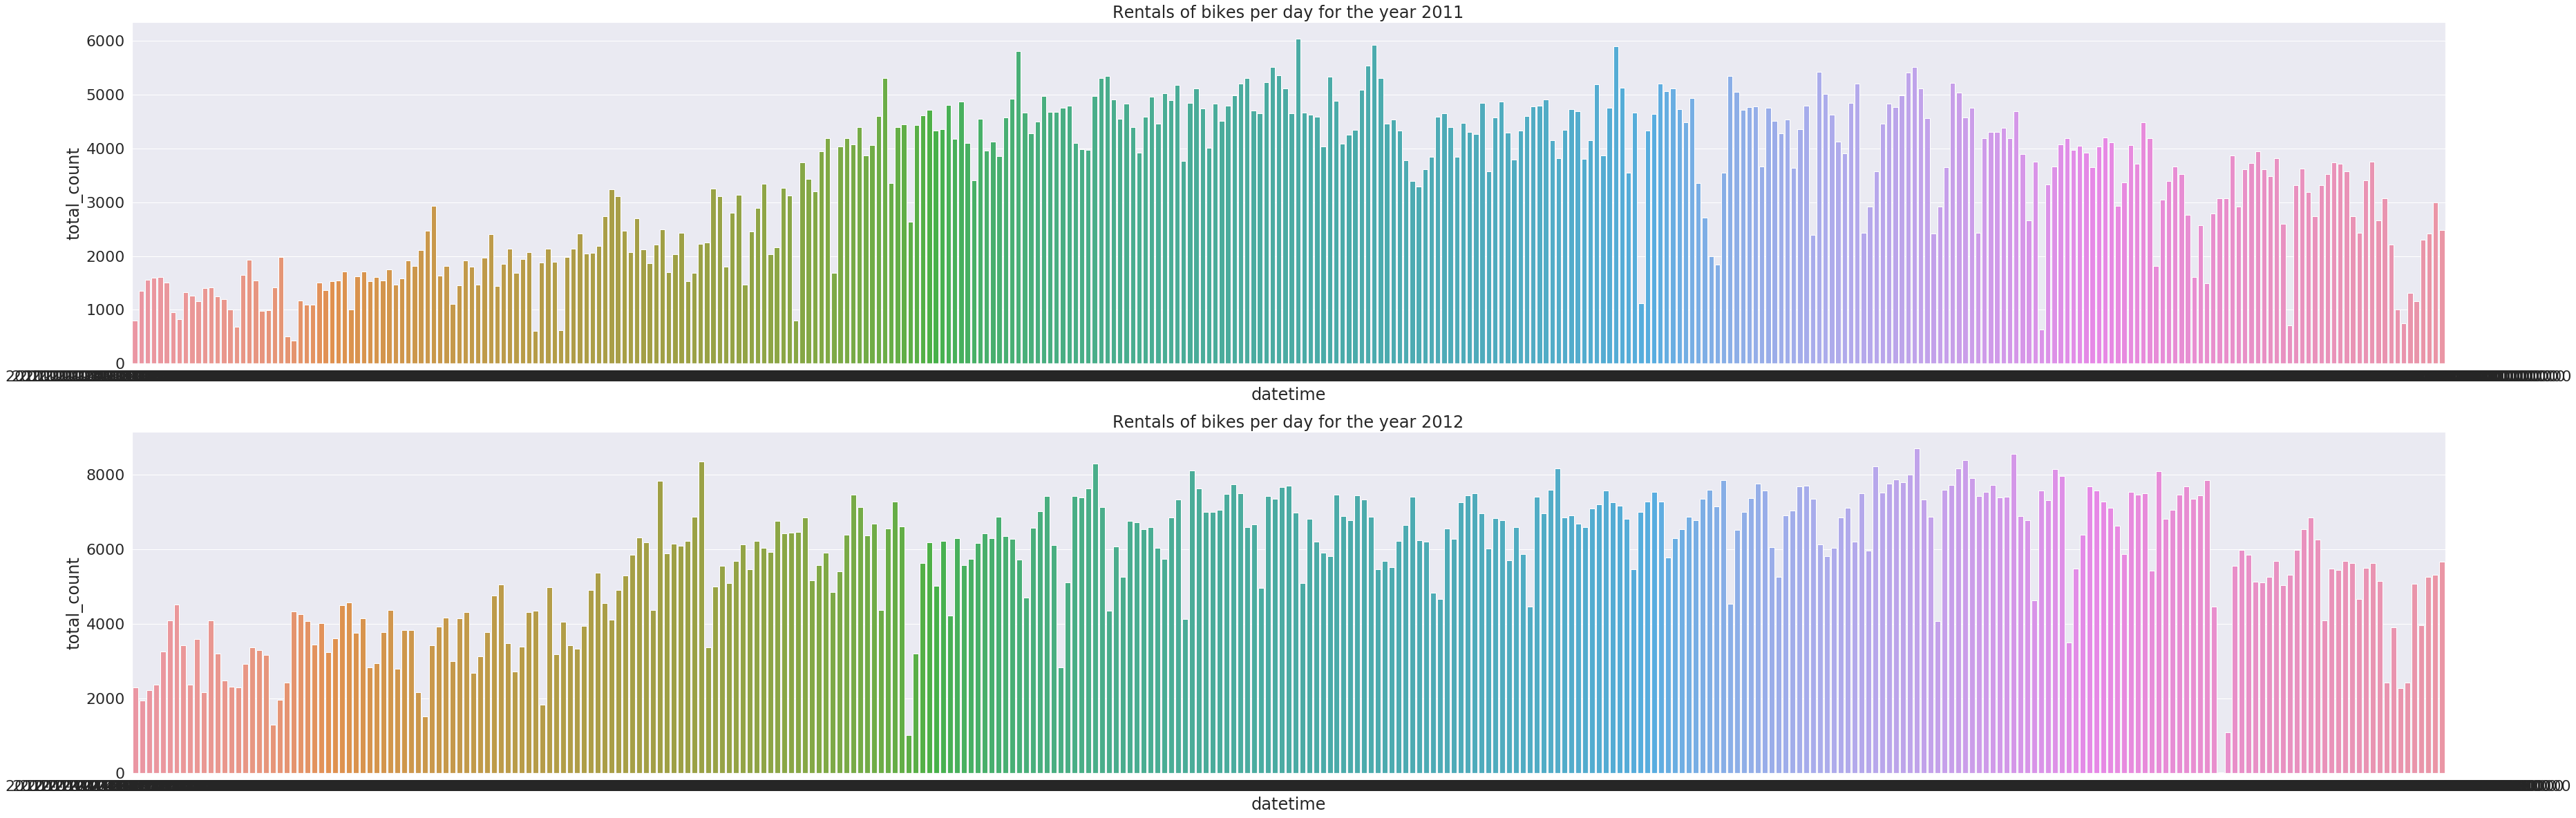

In [9]:
#Visualise rentals of bikes per day for each year
data_2011=day_df[day_df['year'] == 0]
data_2012=day_df[day_df['year'] == 1]

sns.set(font_scale=2)
figure, axes = plt.subplots(nrows=2)
figure.set_size_inches(60, 20)
sns.set_style('white')
sns.barplot(x='datetime',y='total_count',data=data_2011[['datetime','total_count']], ax=axes[0]).set(title="Rentals of bikes per day for the year 2011")
sns.barplot(x='datetime',y='total_count',data=data_2012[['datetime','total_count']], ax=axes[1]).set(title="Rentals of bikes per day for the year 2012")

plt.show()

***Assume that each bike has exactly maximum 12 rentals per day.
Find the maximum number of bicycles nmax that was needed in any one day.***

In [10]:
each_bike_max_rental_daily = 12
nmax = np.ceil(max(day_df['total_count'])/each_bike_max_rental_daily)  
# nmax is maximum number of bicycles that was needed in any one day
nmax

727.0

*** Find the 95%-percentile of bicycles n95 that was needed in any one day. ***

In [11]:
n95 = np.ceil((day_df['total_count'].describe(percentiles=[0.95])['95%'])/12)
# n95 is 95 percentile of bicycles that was needed in any one day.
n95

632.0

In [12]:
day_df["available_bike"] = np.ceil((day_df['total_count'])/each_bike_max_rental_daily)

Vizalize the distribution of the covered days depending on the number of available bicycles (e.g. nmax bicycles would cover 100% of days, n95 covers 95%, etc.

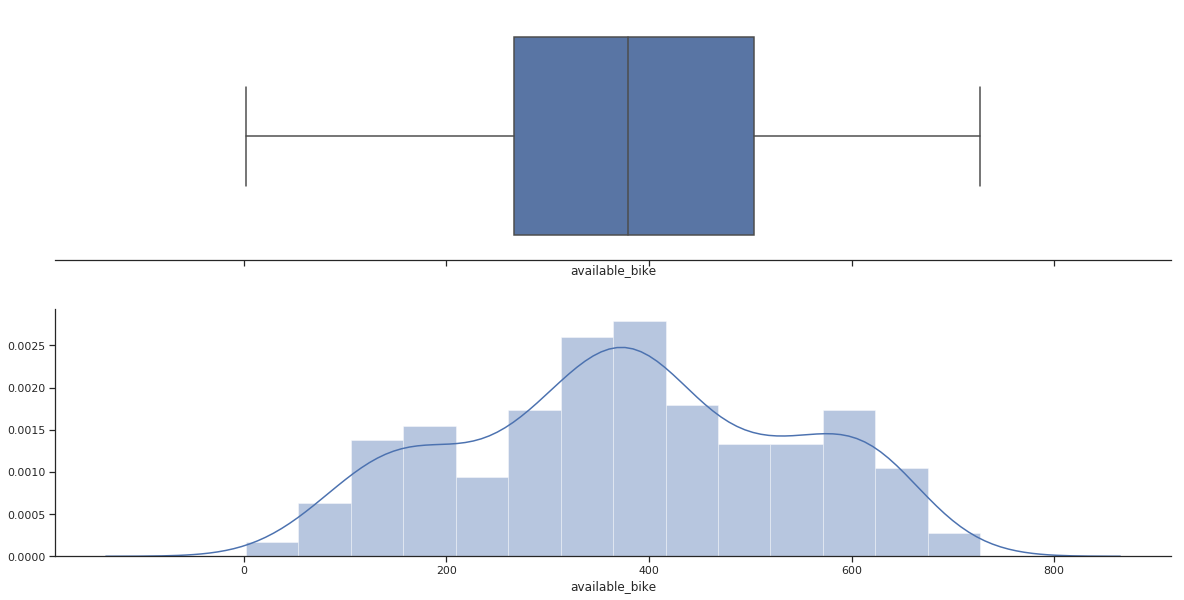

In [13]:
sns.set(style="ticks")

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.5, .5)})
f.set_size_inches(20, 10)

sns.boxplot(day_df["available_bike"], ax=ax_box)
sns.distplot(day_df["available_bike"], ax=ax_hist)

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
plt.show()

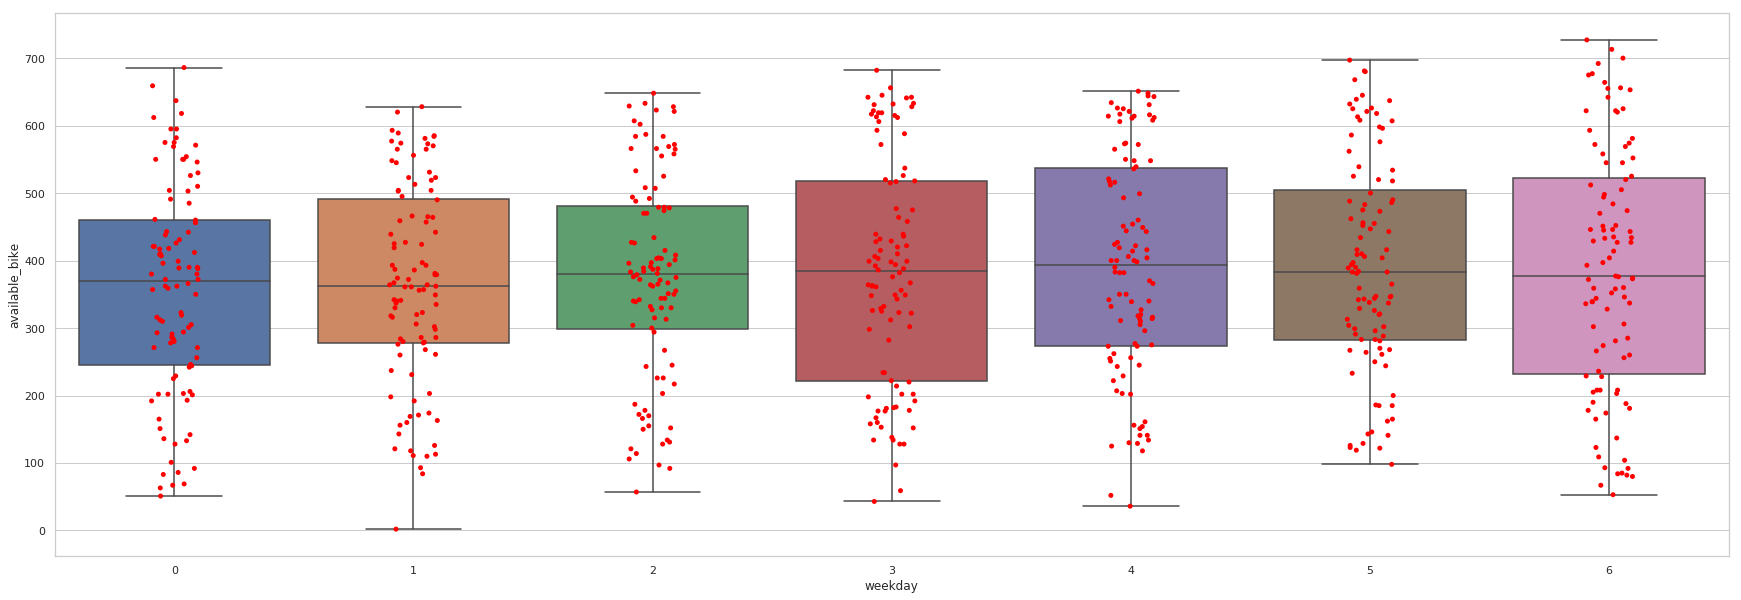

In [14]:
plt.figure(figsize=(30,10))
sns.set_style('whitegrid')
ax= sns.boxplot(x= "weekday", y="available_bike", data=day_df )
ax = sns.stripplot(x= "weekday", y="available_bike", data=day_df, color='red')
plt.show()

**Feature Selection**

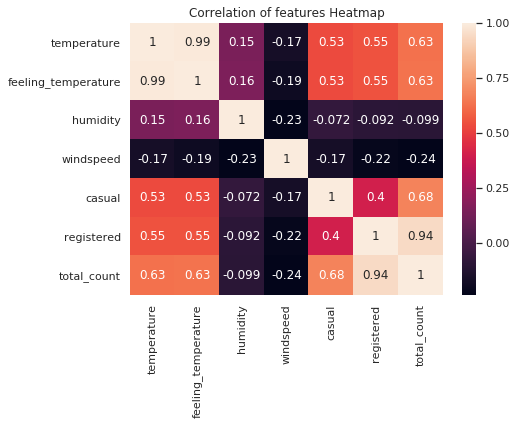

In [15]:
plt.subplots(figsize=(7,5))
sns.set(font_scale=1.0)
ax = plt.axes()
ax.set_title("Correlation of features Heatmap")
corrMatt = day_df[['temperature',
                    'feeling_temperature', 
                    'humidity', 
                    'windspeed', 
                    'casual', 
                    'registered', 
                    'total_count']].corr()
sns.heatmap(corrMatt, 
            xticklabels=corrMatt.columns.values,
            yticklabels=corrMatt.columns.values,
            annot=True)
plt.show()

**Interpretation :**

Casual and registered contain direct information about the bike sharing total count which is to predict. Therefore, they are not considered in the feature set to prevent data leakage.

The variables "temperature" and "feeling_temperature" are strongly correlated. To reduce the dimensionality of the predictive model, the feature "feeling_temperature" is dismissed.

In [16]:
features.remove('casual')
features.remove('registered')
features.remove('feeling_temperature')
features.remove('year')

## Part 3 - Building prediction models

**Tasks:**
1. Define a test metric for predicting the daily demand for bike sharing, which you would like to use to measure the accuracy of the constructed models, and explain your choice.
2. Build a demand prediction model with Random Forest, preferably making use of following python libraries: scikit-learn. 
3. Report the value of the chosen test metric on the provided data. 

**Data is time-based with date column. Therefore train, test split has been done manually. We should not use the sklearn's train_test_split() function to split time data as it splits randomly. **

In [17]:
df1 = day_df[features]
X_train, X_test = df1.iloc[0:550, :].values, df1.iloc[550:, :].values

df2 = day_df[target]
y_train, y_test  = df2.iloc[0:550, :].values.ravel(), df2.iloc[550:, :].values.ravel()

## Choice of evaluation metric:
#### RMSLE (Root Mean Squared Log Error)
It measures relative error between actual and predicted value. It has high tolerance for outlier predictions.
Moreover, it penalizes the underestimates more as compare to overestimate.
In this case, underestimation of demand is more costly as compared to overestimation of demand, as there can be loss of business due to non-availability of bikes.
Along with RMSLE, RMSE, MAE, MAPE and R2 score would also be calculated.

** Demand prediction model with Random Forest using scikit-learn.**

In [18]:
# Model training
model = RandomForestRegressor(random_state= 42, n_estimators=100)
model.fit(X_train, y_train) 

# Table setup
table = PrettyTable()
table.field_names = ["Model", "Dataset", "RMSE", "MAE", "MAPE","RMSLE", "R² score"]

table.add_row([type(model).__name__, "Training", 
               format(np.sqrt(mean_squared_error(y_train, model.predict(X_train))), '.2f'), 
               format(mean_absolute_error(y_train, model.predict(X_train)), '.2f'),
               format((np.mean(np.abs((y_train - model.predict(X_train)) / y_train)) * 100),  '.2f'),
               format((np.sqrt(mean_squared_log_error(y_train, model.predict(X_train)))), '.2f'),
               format(model.score(X_train,y_train), '.2f')])
        

model.fit(X_test, y_test)
              
table.add_row([type(model).__name__, "Testing", 
               format(np.sqrt(mean_squared_error(y_test, model.predict(X_test))), '.2f'), 
               format(mean_absolute_error(y_test, model.predict(X_test)), '.2f'), 
               format(np.mean(np.abs((y_test - model.predict(X_test)) / y_test)) * 100,  '.2f'),
               format((np.sqrt(mean_squared_log_error(y_test, model.predict(X_test)))), '.2f'),
               format(model.score(X_test,y_test), '.2f')])

print(table)


+-----------------------+----------+--------+--------+-------+-------+----------+
|         Model         | Dataset  |  RMSE  |  MAE   |  MAPE | RMSLE | R² score |
+-----------------------+----------+--------+--------+-------+-------+----------+
| RandomForestRegressor | Training | 275.23 | 188.05 |  7.00 |  0.12 |   0.97   |
| RandomForestRegressor | Testing  | 347.15 | 227.68 | 58.00 |  0.37 |   0.94   |
+-----------------------+----------+--------+--------+-------+-------+----------+


**Feature importance**

In [19]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

Feature ranking:
1. temperature (0.472292)
2. humidity (0.233055)
3. count_lag1 (0.119316)
4. windspeed (0.090348)
5. weekday (0.041656)
6. is_workingday (0.014211)
7. weather_situation (0.009948)
8. month (0.008117)
9. is_holiday (0.007330)
10. season (0.003725)


**Answers / comments / reasoning:**

-

## Part 4 - Fine-tuning of one of the models

**Tasks:**
1. Take one of the above constructed models and finetune its most important hyperparameters
2. Explain your choice for the hyperparameters
3. Report the improvement of your test metric

In [20]:
grid_values = {'random_state':[42],
               'n_estimators':[400, 500, 600],        # Number of trees in random forest
               'criterion':['mse', 'mae'],                 # Evaluation metric       
               'max_depth':[10, 20, 30],              # Maximum number of levels in tree
               'max_features': ['auto', 'sqrt'],          # Number of features to consider at every split
               'min_samples_leaf':[ 1, 2, 3],             # Minimum number of samples required at each leaf node
               'min_samples_split': [2, 3, 4]}               # Minimum number of samples required to split a node             
grid_RFR = GridSearchCV(estimator = model, param_grid=grid_values, cv=TimeSeriesSplit(n_splits=5), n_jobs = -1, verbose = 2)



In [21]:
grid_RFR.fit(X_train, y_train)
grid_RFR.best_params_

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 301 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 949 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 1394 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:  1.7min finished


{'criterion': 'mae',
 'max_depth': 30,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 400,
 'random_state': 42}

In [22]:
best_grid = grid_RFR.best_estimator_

In [23]:
# Model training
model = best_grid
model.fit(X_train, y_train) 

# Table setup
table1 = PrettyTable()
table1.field_names = ["Model", "Dataset", "RMSE", "MAE", "MAPE","RMSLE", "R² score"]

table1.add_row([type(model).__name__, "Training", 
               format(np.sqrt(mean_squared_error(y_train, model.predict(X_train))), '.2f'), 
               format(mean_absolute_error(y_train, model.predict(X_train)), '.2f'),
               format((np.mean(np.abs((y_train - model.predict(X_train)) / y_train)) * 100),  '.2f'),
               format((np.sqrt(mean_squared_log_error(y_train, model.predict(X_train)))), '.2f'),
               format(model.score(X_train,y_train), '.2f')])


model.fit(X_test, y_test) 
table1.add_row([type(model).__name__, "Testing", 
               format(np.sqrt(mean_squared_error(y_test, model.predict(X_test))), '.2f'), 
               format(mean_absolute_error(y_test, model.predict(X_test)), '.2f'), 
               format(np.mean(np.abs((y_test - model.predict(X_test)) / y_test)) * 100,  '.2f'),
               format((np.sqrt(mean_squared_log_error(y_test, model.predict(X_test)))), '.2f'),
               format(model.score(X_test,y_test), '.2f')])

print(table1)

+-----------------------+----------+--------+--------+-------+-------+----------+
|         Model         | Dataset  |  RMSE  |  MAE   |  MAPE | RMSLE | R² score |
+-----------------------+----------+--------+--------+-------+-------+----------+
| RandomForestRegressor | Training | 292.93 | 198.83 |  7.39 |  0.13 |   0.97   |
| RandomForestRegressor | Testing  | 363.91 | 235.66 | 60.70 |  0.37 |   0.93   |
+-----------------------+----------+--------+--------+-------+-------+----------+


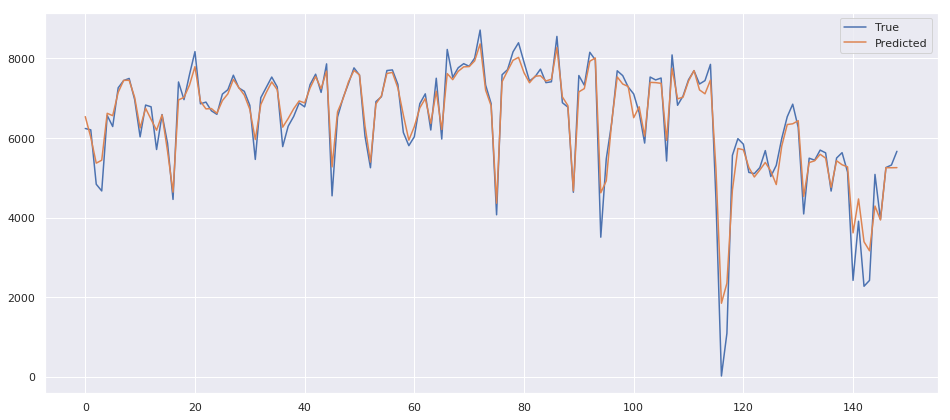

In [24]:
plt.figure(figsize = (16, 7))
plt.plot(y_test, label = "True")
plt.plot(model.predict(X_test), label = "Predicted")
plt.legend()
plt.show()

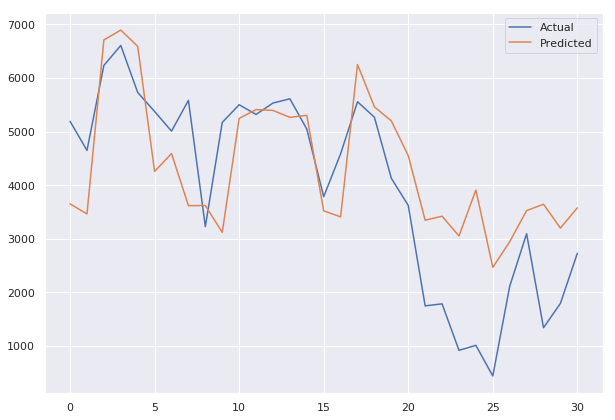

In [25]:

plt.figure(figsize = (10, 7))
plt.plot(last30days_df[['total_count']].reset_index(drop=True), label = "Actual")
plt.plot(model.predict(last30days_df[features]), label = "Predicted")
plt.legend()
plt.show()

**Interpretaion:**
Prediction is considerably good except during the christmas week as it is an extreme holiday scenario.

## Part 5 - Optimise (revenue - cost) by adapting number of bicycles
**Tasks:**
1. Assume that the revenue per rental is x (your own assumed number).
2. Each bicycle has costs of y per day (your own assumed number).
3. Determine residuals from your test set (after predicting demand of bike sharing). Consider the residuals as random shocks affecting the average values and resulting in real observed values. Assume this random variable is gaussian distributed. Calculate mean and standard deviation and use it as approximation for a gaussian distribution where you can sample from.
4. Simulate the profit with a fixed number of `nmax` (from part 2) bicycles for the next 30 days given that the real observed values are expected to be different from average predicted values. Calculate the demand by adding the simulated residuals to calculated expected values from the data you put aside in part 1.
5. Use grid search along the number of available bikes to find the optimal number of bikes to obtain highest profit (revenue - cost) from simulations.


In [26]:
def get_profit(num_of_bikes, num_of_rentals):
    ## Assumptions
    revenue_per_rental = 5
    cost_per_bike_per_day = 20
    
    cost = num_of_bikes * cost_per_bike_per_day
    
    ## each bike can be rented at max 12 times per day
    tmp_rentals = num_of_bikes*12
    if tmp_rentals < num_of_rentals:
        num_of_rentals = tmp_rentals
        
    revenue = num_of_rentals * revenue_per_rental
    profit = revenue-cost
    return(profit)

def optimum_bike_count(predicted_rentals):
    num_of_bikes = int(nmax) ## From part 2
    t = [{ x : get_profit(x, predicted_rentals)} for x in list(range(num_of_bikes))] #list of dict - rentalbikes count on daily basis and profit
    tdict = {k:v for element in t for k,v in element.items()} #dict of dict with same info as t. Reordering data.
    return(max(tdict, key=tdict.get))               # combination for max profit with its corresponding bike count

In [27]:
# residuals on test set per day basis
from scipy.stats import norm

test_residuals = y_test - model.predict(X_test)
mu, std = norm.fit(test_residuals)
print("Mean: {0}".format(mu))
print("Standard deviation: {0}".format(std))

Mean: -15.064907718120832
Standard deviation: 363.60012769228496


In [28]:
## Randomly sample residuals from the distribution (noise)
last30days_df['simulated_residuals'] = np.random.normal(mu, std, last30days_df.shape[0])

In [29]:
last30days_df["predicted_count"] = model.predict(last30days_df[features])

In [30]:
## Add residuals/noise to predicted values
last30days_df["residual_prediction"] = round(last30days_df["predicted_count"] + last30days_df['simulated_residuals'])
last30days_df["optimum_bike_count"] = last30days_df["residual_prediction"].apply(lambda x: optimum_bike_count(x)) #array of predicted bike rental count 

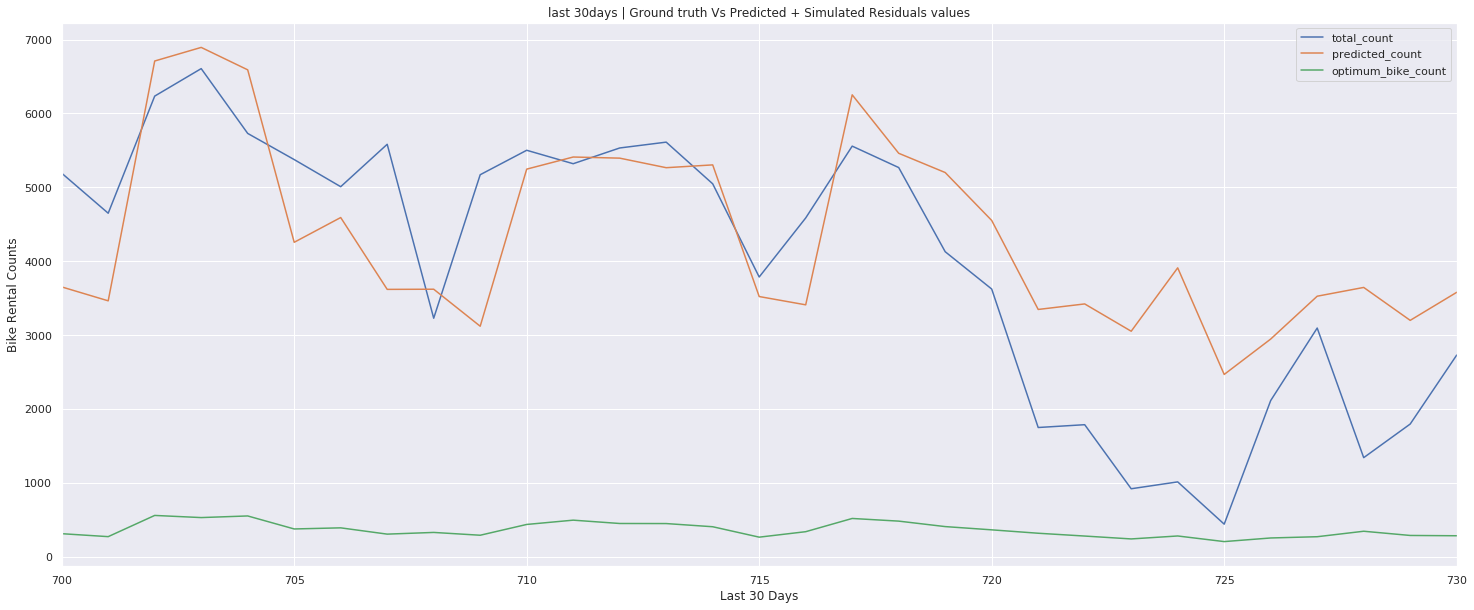

In [31]:
rcParams['figure.figsize'] = 25, 10

last30days_df["total_count"].plot()
#last30days_df["residual_prediction"].plot()
last30days_df["predicted_count"].plot()
last30days_df["optimum_bike_count"].plot()

plt.legend(loc="best")
plt.title("last 30days | Ground truth Vs Predicted + Simulated Residuals values")
plt.ylabel("Bike Rental Counts")
plt.xlabel("Last 30 Days")
plt.show()

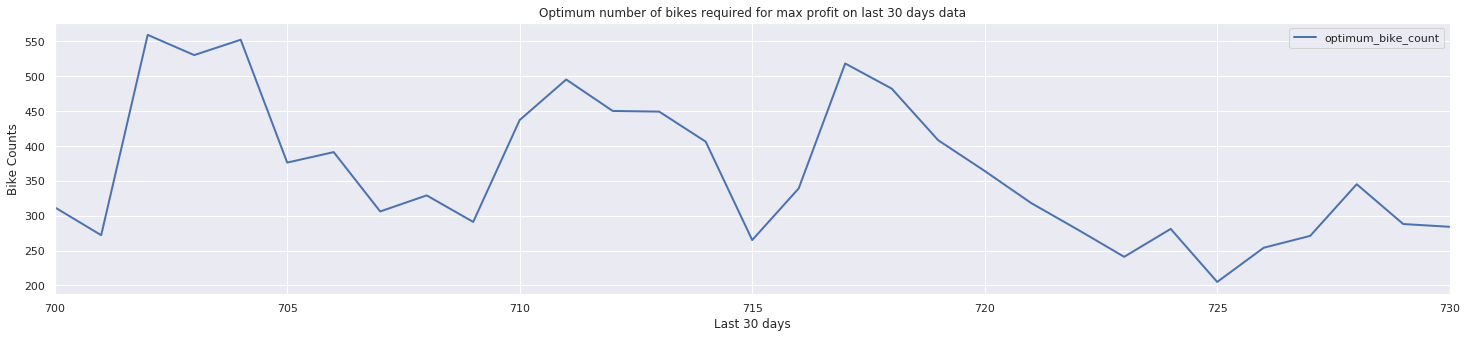

In [32]:
rcParams['figure.figsize'] = 25, 5


last30days_df["optimum_bike_count"].plot(linewidth=2)

plt.legend(loc="best")
plt.title("Optimum number of bikes required for max profit on last 30 days data")
plt.ylabel("Bike Counts")
plt.xlabel("Last 30 days")
plt.show()

**Answers / comments / reasoning:**

-

## Part 6 - Reflection / comments

**Tasks:**
(Optional) Please share with us any free form reflection, comments or feedback you have in the context of this test task.

## Submission

Please submit this notebook with your developments in .ipynb and .html formats as well as your requirements.txt file.

## References

[1] Lichman, M. (2013). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.